**Project** **Title**





Drought Risk Prediction and Early-Warning Insights Extraction

**Problem** **Statement**

Droughts cause severe water scarcity and crop loss; hence, a machine learning model is needed to predict drought risk levels (Low, Medium, High) using climatic, soil, and hydrological data for early warning and planning.






**Description**

This project focuses on building a machine learning–based drought risk prediction system. The model analyzes multiple environmental indicators such as rainfall, temperature, soil moisture, vegetation index (NDVI), humidity, wind speed, river flow, elevation, and ENSO (El Niño/La Niña conditions) to classify drought risk levels as Low, Medium, or High.

By learning from past climatic and environmental data, the system provides early warning insights that can support farmers, water resource managers, and policymakers in making informed decisions. The goal is to improve drought preparedness, optimize water management, reduce agricultural losses, and ensure food security.

In [ ]:
# Step 1: Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os


In [ ]:
# Step 2: Upload CSV
# -----------------------------
from google.colab import files
import pandas as pd

# Read the uploaded CSV
df = pd.read_csv("drought_dataset_rows.csv")

print(" CSV Uploaded & Loaded!")
print(df.head(10))


Saving drought_dataset_rows.csv.csv to drought_dataset_rows.csv.csv
 CSV Uploaded & Loaded!
   Rainfall_mm  Temperature_C  Soil_Moisture  NDVI  Humidity  Wind_Speed  \
0           12             32           0.18  0.21        42          14   
1           85             27           0.62  0.48        71           9   
2           45             29           0.40  0.36        60          12   
3           10             34           0.15  0.19        38          18   
4           90             26           0.65  0.55        75           8   
5           30             31           0.35  0.28        55          13   
6           60             28           0.55  0.46        65          11   
7           15             35           0.20  0.23        40          16   
8           70             27           0.60  0.50        70          10   
9           25             33           0.25  0.27        45          15   

   River_Flow  Elevation_m          Region        Season     ENSO Droug

In [ ]:
# Step 2B: Basic Info about Dataset
# ---------------------------------
print("🔹 First 5 Rows of Dataset:")
print(df.head())

print("\n🔹 Dataset Shape (rows, columns):", df.shape)

print("\n🔹 Column Names:")
print(df.columns)

print("\n🔹 Data Types:")
print(df.dtypes)

print("\n🔹 Missing Values in Each Column:")
print(df.isnull().sum())

print("\n🔹 Statistical Summary (numerical columns):")
print(df.describe())


🔹 First 5 Rows of Dataset:
   Rainfall_mm  Temperature_C  Soil_Moisture  NDVI  Humidity  Wind_Speed  \
0           12             32           0.18  0.21        42          14   
1           85             27           0.62  0.48        71           9   
2           45             29           0.40  0.36        60          12   
3           10             34           0.15  0.19        38          18   
4           90             26           0.65  0.55        75           8   

   River_Flow  Elevation_m          Region        Season     ENSO Drought_Risk  
0         102          320       Telangana   Pre-Monsoon   ElNino         High  
1         215          280     Maharashtra       Monsoon  Neutral          Low  
2         175          300       Karnataka  Post-Monsoon   LaNina       Medium  
3          98          400  Andhra Pradesh   Pre-Monsoon   ElNino         High  
4         220          290         Gujarat       Monsoon  Neutral          Low  

🔹 Dataset Shape (rows, column

Saving drought_dataset_rows.csv.csv to drought_dataset_rows.csv (8).csv
 Loaded file: drought_dataset_rows.csv (8).csv
   Rainfall_mm  Temperature_C  Soil_Moisture  NDVI  Humidity  Wind_Speed  \
0           12             32           0.18  0.21        42          14   
1           85             27           0.62  0.48        71           9   
2           45             29           0.40  0.36        60          12   
3           10             34           0.15  0.19        38          18   
4           90             26           0.65  0.55        75           8   

   River_Flow  Elevation_m          Region        Season     ENSO Drought_Risk  
0         102          320       Telangana   Pre-Monsoon   ElNino         High  
1         215          280     Maharashtra       Monsoon  Neutral          Low  
2         175          300       Karnataka  Post-Monsoon   LaNina       Medium  
3          98          400  Andhra Pradesh   Pre-Monsoon   ElNino         High  
4         220      

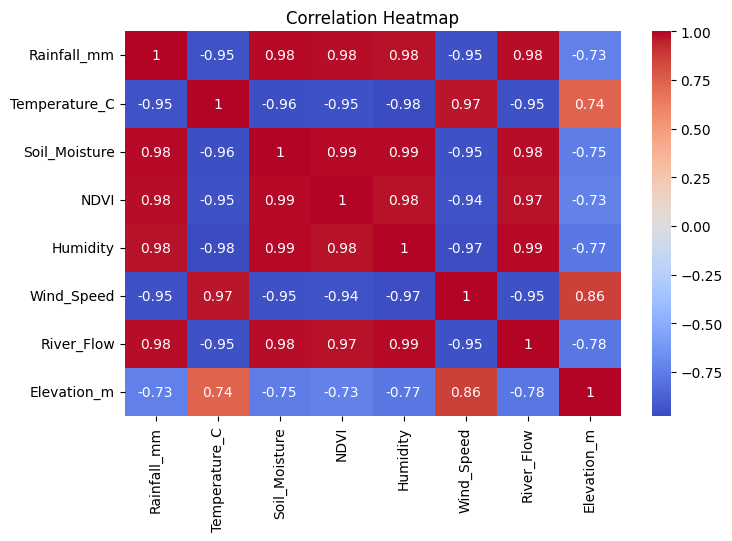

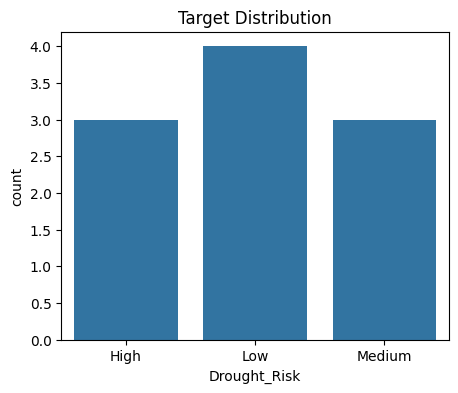


 Data transformed. Shape: (10, 23)


In [9]:

# Step 1: Upload + Load dataset
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

print(" Loaded file:", filename)
print(df.head())

#Step 2: Exploratory Data Analysis (EDA)

print("\n--- Dataset Info ---")
print(df.info())

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Summary Statistics ---")
print(df.describe(include="all"))

# Correlation heatmap (only numeric)
plt.figure(figsize=(8, 5))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Target distribution
plt.figure(figsize=(5,4))
sns.countplot(x="Drought_Risk", data=df)
plt.title("Target Distribution")
plt.show()

# Step 3: Data Transformation
num_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()
num_cols.remove("Elevation_m") if "Elevation_m" in num_cols else None  # optional
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
target = "Drought_Risk"

if target in num_cols: num_cols.remove(target)
if target in cat_cols: cat_cols.remove(target)

X = df.drop(columns=[target])
y = df[target]

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

X_transformed = preprocess.fit_transform(X)
print("\n Data transformed. Shape:", X_transformed.shape)




--- Top Features ---
                    Feature  Importance
4             num__Humidity    0.123437
3                 num__NDVI    0.092098
7          num__Elevation_m    0.088659
5           num__Wind_Speed    0.082237
2        num__Soil_Moisture    0.081292
6           num__River_Flow    0.080437
0          num__Rainfall_mm    0.072831
18         cat__ENSO_ElNino    0.057210
20        cat__ENSO_Neutral    0.052621
17  cat__Season_Pre-Monsoon    0.050756


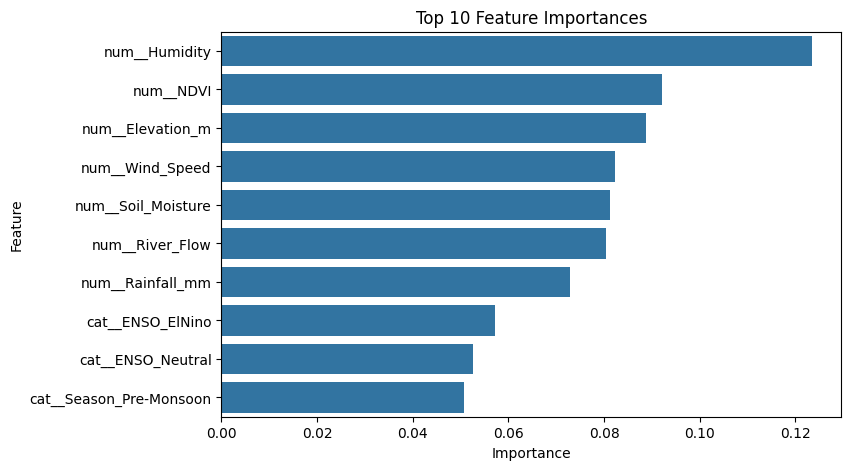

In [13]:


# Step 4: Feature Selection

# Define numerical & categorical columns
num_cols = ["Rainfall_mm", "Temperature_C", "Soil_Moisture", "NDVI",
            "Humidity", "Wind_Speed", "River_Flow", "Elevation_m"]
cat_cols = ["Region", "Season", "ENSO"]

# Preprocessing: scale numeric + encode categorical
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Pipeline: preprocessing + RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
pipe = Pipeline(steps=[("prep", preprocess), ("model", rf)])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Fit pipeline
pipe.fit(X_train, y_train)

# Get feature names after transformation
feature_names = pipe.named_steps["prep"].get_feature_names_out()
importances = pipe.named_steps["model"].feature_importances_

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\n--- Top Features ---")
print(feat_imp.head(10))

# Plot top features
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(10))
plt.title("Top 10 Feature Importances")
plt.show()